In [135]:
import numpy as np
import datetime as dt 
import pandas as pd
import pandas_datareader.data as web
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from arch import arch_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [136]:
df = pd.read_csv("new_^IXIC.csv")

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Print prices of selected stock for start and end date
print(pd.concat([df.head(1), df.tail(1)]))# Set date ranges:
# Start date
start = dt.datetime(2020,7,27)
# End date
end = dt.datetime(2023,7,21)

# Set symbol name
symbol_name = 'NASDAQ Composite (^IXIC)'

                    Open          High           Low         Close  \
Date                                                                 
2020-07-27  10421.700195  10546.440430  10399.860352  10536.269531   
2023-07-21  14148.179688  14179.009766  14020.450195  14032.809570   

               Adj Close        Volume  truth  
Date                                           
2020-07-27  10536.269531  4.244570e+09      1  
2023-07-21  14032.809570  5.254180e+09      1  


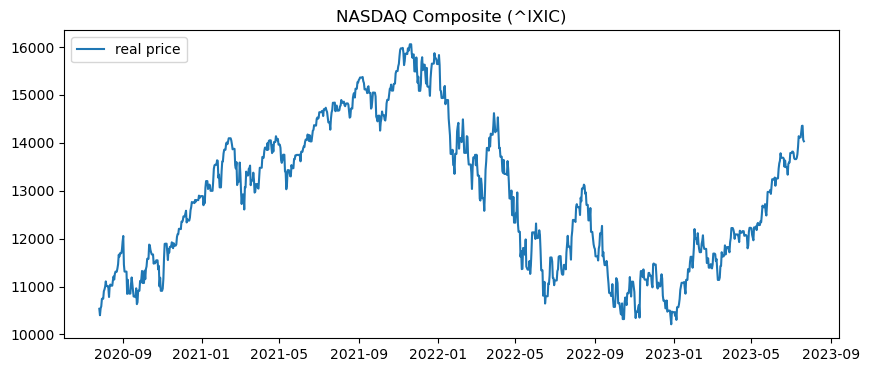

In [137]:
# Plot historical price data
plt.figure(figsize=(10,4))
plt.title(symbol_name)
plt.plot(df['Close'], label='real price')
plt.legend(loc = 'upper left')
plt.show()

Train: 763, Test: 327


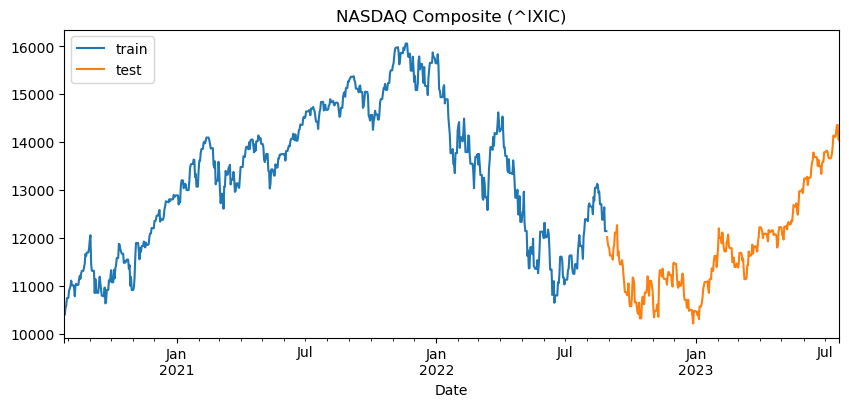

In [138]:
# Train test split
def train_test_split(X, size=0.7):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

train, test = train_test_split(X=df['Close'], size=0.7)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test datasets
fig, ax = plt.subplots(figsize=(10,4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
plt.title('NASDAQ Composite (^IXIC)')
ax.legend(loc = 'upper left')
plt.show()

In [139]:
# Calculate volatility
def returns_vol(df, column):
    # Calculate returns as percentage of price changes
    df['Returns'] = df[column].pct_change()*100
    # Calculate daily std of returns
    volatility = df['Returns'].std()
    df.dropna(inplace=True)
    return df, volatility

df, volatility = returns_vol(df, column='Close')

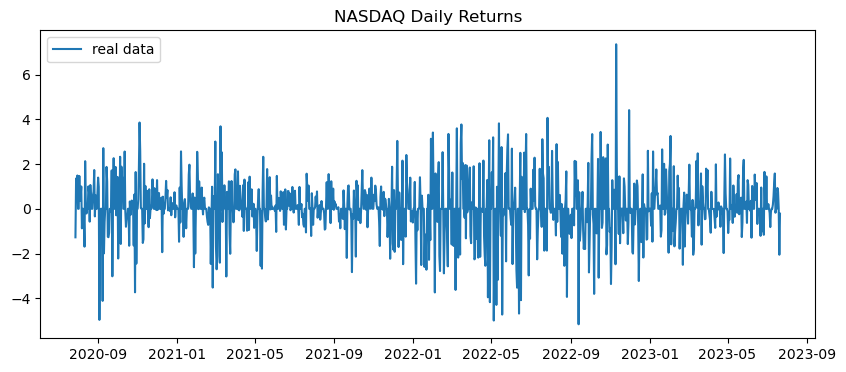

Daily volatility: 1.27% 
Monthly volatility: 6.96% 
Annual volatility: 24.27% 


In [140]:
# Plot the price returns
plt.figure(figsize=(10,4))
plt.plot(df['Returns'], label='real data')
plt.title('NASDAQ Daily Returns')
plt.legend(loc = 'upper left')
plt.show()

# Print volatility
print(f'''Daily volatility: {volatility:.2f}% 
Monthly volatility: {np.sqrt(30)*volatility:.2f}% 
Annual volatility: {np.sqrt(365)*volatility:.2f}% ''')

In [141]:
# Specify GARCH model function
def garch_model(df, p=1, o=0, q=1, mean='constant', vol = 'GARCH', 
                dist='normal'):
    model = arch_model(
        df, 
        p = p, o=o, q = q, 
        mean = mean,
        vol = vol,
        dist = dist
    )
    return model

In [142]:
# Implement a basic GARCH model
basic_gm = garch_model(df['Returns']) 
# Fit the model
gm_result = basic_gm.fit(disp='off', show_warning=False)

# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1722.46
Distribution:                  Normal   AIC:                           3452.92
Method:            Maximum Likelihood   BIC:                           3472.89
                                        No. Observations:                 1089
Date:                Sun, Aug 06 2023   Df Residuals:                     1088
Time:                        22:41:38   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0686  3.509e-02      1.956  5.051e-02 [-1.53

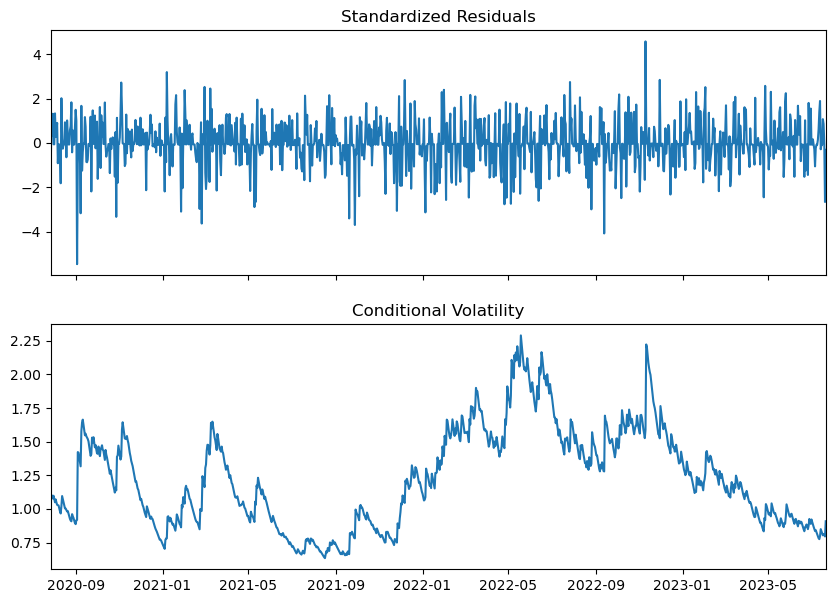

In [143]:
# Plot fitted results
plt.rc("figure", figsize=(10, 7))
gm_result.plot()
plt.show()

In [144]:
# Obtain model estimated residuals and volatility
# Residual = predicted price - real price
gm_resid = gm_result.resid
# Predicted price volatility (std)
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid / gm_std

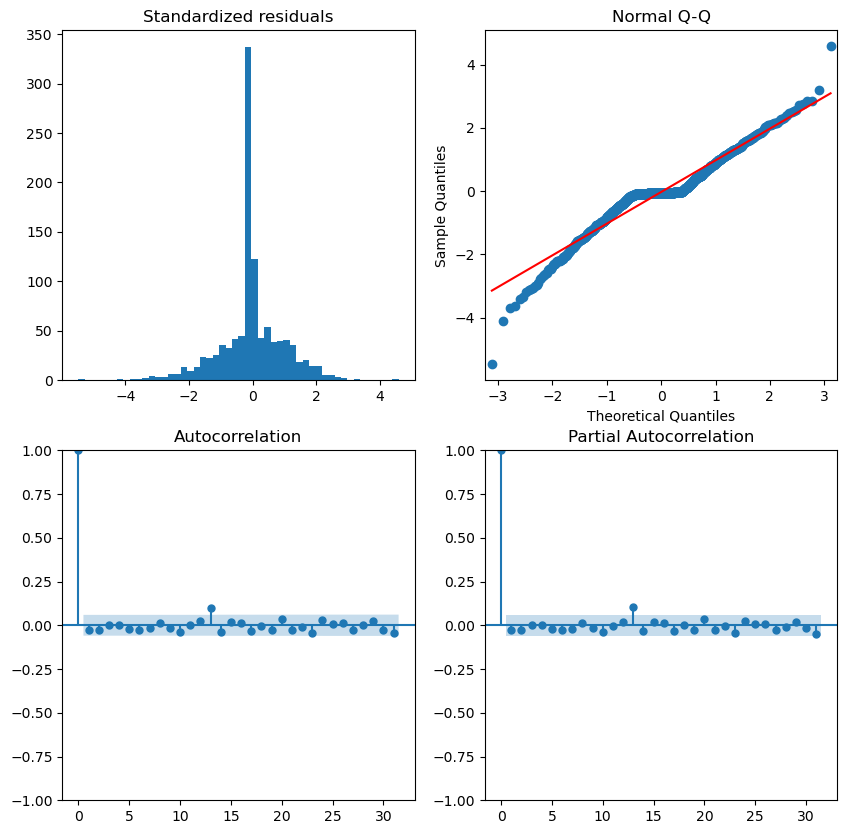

In [145]:
# Diagnose plot of residuals
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.hist(gm_std_resid, bins = 50)
ax1.set_title('Standardized residuals')
qqplot(gm_std_resid, line='s', ax=ax2)
ax2.set_title('Normal Q-Q')
plot_acf(gm_std_resid, ax=ax3)
plot_pacf(gm_std_resid, ax=ax4)
plt.show()

In [146]:
# Specify GJR-GARCH model assumptions
gjr_gm = garch_model(df['Returns'], o=1, dist = 'skewt') 

# Fit the model
gjr_result = gjr_gm.fit(disp='off', show_warning=False)

# Get model estimated volatility
gjr_vol = gjr_result.conditional_volatility

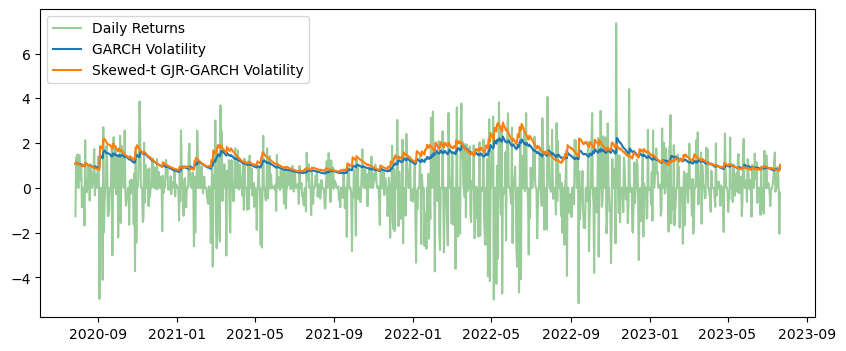

Correlation coef between GARCH and skewed-t GJR=GARCH: 0.93


In [148]:
# Plot model fitting results
plt.rc("figure", figsize=(10, 4))
gm_vol = gm_result.conditional_volatility
plt.plot(df['Returns'], color = 'green', 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(gm_vol, label = 'GARCH Volatility')
plt.plot(gjr_vol, label = 'Skewed-t GJR-GARCH Volatility')
plt.legend(loc = 'upper left')
plt.show()
print(f'Correlation coef between GARCH and skewed-t GJR=GARCH: {round(np.corrcoef(gm_vol, gjr_vol)[0,1],2)}')

In [149]:
# In-sample rolling window one-step-forecast
index = df.index
end_loc = 1035
forecasts = {}
for i in range(50):
    # Specify fixed rolling window size for model fitting
    gm_result = basic_gm.fit(last_obs = i + end_loc,
                             disp='off', show_warning=False)
    # Conduct 1-period variance forecast and save the result
    temp_result = gm_result.forecast(horizon = 1, reindex=True).variance
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast
# Save all forecast to a dataframe    
forecast_var = pd.DataFrame(forecasts).T

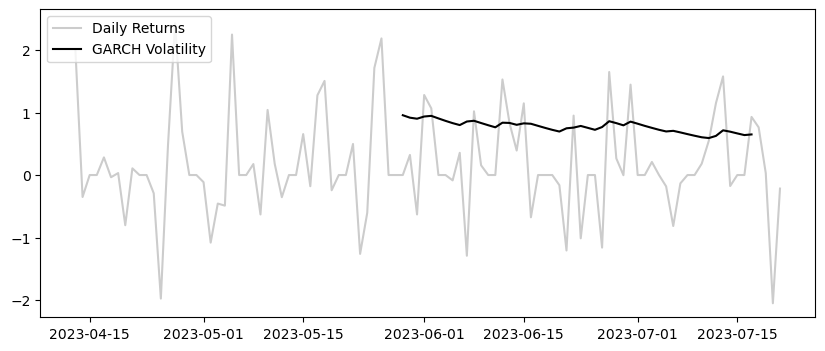

In [150]:
# Plot in-sample forecast and real volatility
plt.plot(df.Returns[-100:], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.plot(forecast_var, label = 'GARCH Volatility', color = 'black')
plt.legend(loc = 'upper left')
plt.show()

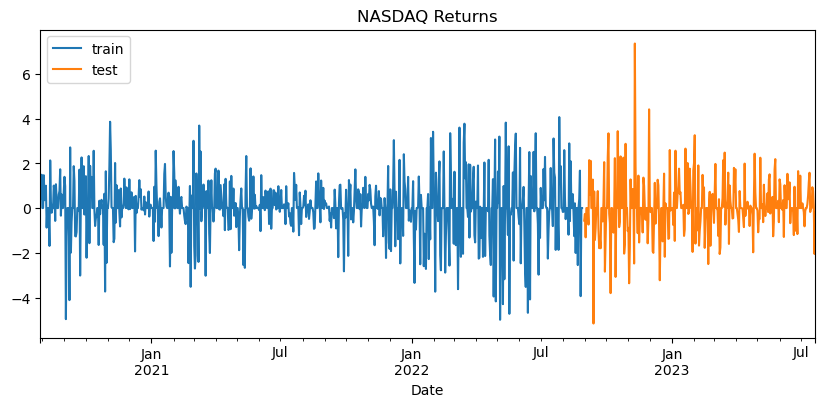

In [152]:
# Now let's try forecast on test date
test = pd.DataFrame(test)
train = pd.DataFrame(train)
train, _ = returns_vol(train, column='Close')
test, _ = returns_vol(test, column='Close')

# Plot train & test returns
fig, ax = plt.subplots(figsize=(10,4))
train['Returns'].plot(ax=ax, label='train')
test['Returns'].plot(ax=ax, label='test')
plt.title('NASDAQ Returns')
ax.legend(loc = 'upper left')
plt.show()

In [153]:
# Out-of-sample rolling window one-step-forecast
rolling_predictions = []
for i in range(test.shape[0]):
    model = garch_model(train['Returns'], p=1, o=0, q=1)
    model_fit = model.fit(update_freq=1, disp='off')
    pred = model_fit.forecast(horizon=1, reindex=True)
    train = pd.concat([train, test.iloc[[i]]], axis=0, ignore_index=True)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1, :][0]))

In [154]:
rolling_predictions = pd.DataFrame(rolling_predictions, index=test.index)
print(rolling_predictions)

                   0
Date                
2022-08-31  1.545370
2022-09-01  1.494548
2022-09-02  1.439675
2022-09-03  1.434615
2022-09-04  1.380425
...              ...
2023-07-17  0.798791
2023-07-18  0.806163
2023-07-19  0.804747
2023-07-20  0.788259
2023-07-21  0.911254

[325 rows x 1 columns]


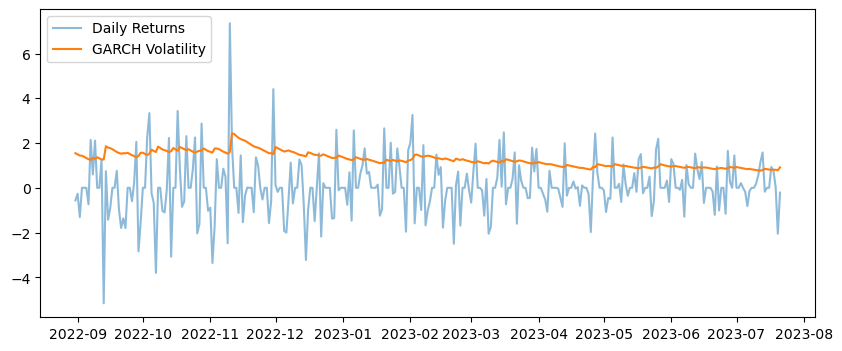

In [155]:
plt.plot(test['Returns'], 
         label = 'Daily Returns', alpha = 0.5)
plt.plot(rolling_predictions, 
         label = 'GARCH Volatility')
plt.legend(loc = 'upper left')